<a href="https://colab.research.google.com/github/Isaac-Hirsch/ChessBot/blob/main/Chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.2 MB/s eta 0:00:00


In [2]:
import chess
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import torch
from chess import svg
import IPython

In [3]:
board=chess.Board()

In [4]:
#display(IPython.display.HTML(svg.board(board=board, size=300)))

In [5]:
print(chess.square_name(52))

e7


# Test how to create boards and play moves on them. Also test how fast it is.

In [6]:
board=chess.Board()

In [7]:
i=0
for move in board.legal_moves:
  i+=1

print(i)

20


In [8]:
board.reset()
print(board.move_stack)
board.push(chess.Move.from_uci('e2e4'))
print(board.move_stack)
board.push(chess.Move.from_uci('e7e5'))
print(board.move_stack)
board.push(chess.Move.from_uci('g1f3'))
print(board.move_stack)
board.push(chess.Move.from_uci('b8c6'))
print(board.move_stack)
i=0
for move in board.legal_moves:
  i+=1

print(len(list(board.legal_moves)))
#display(IPython.display.HTML(svg.board(board=board)))

[]
[Move.from_uci('e2e4')]
[Move.from_uci('e2e4'), Move.from_uci('e7e5')]
[Move.from_uci('e2e4'), Move.from_uci('e7e5'), Move.from_uci('g1f3')]
[Move.from_uci('e2e4'), Move.from_uci('e7e5'), Move.from_uci('g1f3'), Move.from_uci('b8c6')]
27


In [9]:
def depth_search(board, depth, num_pos):
  if depth==0:
    return num_pos+len(list(board.legal_moves))
  else:
    for move in board.legal_moves:
      board.push(move)
      num_pos=depth_search(board, depth-1, num_pos)
      board.pop()
    return num_pos

In [10]:
board.reset()
print(depth_search(board, 4, 0))

4865609


In [11]:
#Try to remove the minmax variable
def alpha_beta(board, evaluator, depth, max, alpha=-np.inf, beta=np.inf):
  if depth==0:
    return evaluator(board)
  elif max:
    for move in board.legal_moves:
      board.push(move)
      eva=alpha_beta(board, evaluator, depth-1, False, alpha, beta)
      maxEva=max(maxEva, eva)
      board.pop()
      alpha=max(alpha, eva)
      if beta<=alpha:
        break
    return maxEva
  else:
    for move in board.legal_moves:
      board.push(move)
      eva=alpha_beta(board, evaluator, depth-1, True, alpha, beta)
      minEva=min(minEva, eva)
      board.pop()
      alpha=min(beta, eva)
      if beta<=alpha:
        break
    return minEva

In [12]:
def evaluate_position(board):
    # Check for endgame scenarios
    if board.is_checkmate():
        if board.turn == chess.WHITE:
            return -np.inf  # Black wins
        else:
            return np.inf  # White wins
    elif board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
        return 0  # Draw

    # Material values
    piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9}

    # Calculate material balance
    material_balance = 0
    for piece_type in piece_values:
        material_balance += len(board.pieces(piece_type, chess.WHITE)) * piece_values[piece_type]
        material_balance -= len(board.pieces(piece_type, chess.BLACK)) * piece_values[piece_type]

    # Basic positional factors
    center_squares = [chess.D4, chess.E4, chess.D5, chess.E5]
    for square in center_squares:
        if board.piece_at(square):
            if board.piece_at(square).color == chess.WHITE:
                material_balance += 0.1  # Slight advantage for controlling a center square
            else:
                material_balance -= 0.1

    # Piece activity
    white_mobility = len(list(board.legal_moves))
    board.push(chess.Move.null())  # Switch turn to get mobility for the other side
    black_mobility = len(list(board.legal_moves))
    board.pop()  # Revert the null move
    mobility_balance = 0.01 * (white_mobility - black_mobility)

    # Check for "king and queen vs king" or "king and rook vs king" scenarios
    if len(board.piece_map()) == 3:
        if board.has_queen() or board.has_rook():
            # Reward for minimizing the opposing king's mobility
            opposing_color = not board.turn
            king_mobility = evaluate_king_mobility(board, opposing_color)
            mobility_score = -0.5 * king_mobility  # Negative score as we want to minimize this
            return material_balance + mobility_balance + 100 + mobility_score  # Add base score for having a queen/rook advantage

    return material_balance + mobility_balance

def evaluate_king_mobility(board, color):
    # Temporarily switch turns to calculate the opponent's king's legal moves
    board.push(chess.Move.null())
    king_moves = list(board.generate_legal_moves())
    board.pop()

    # Filter moves for the king
    king_square = board.king(color)
    king_moves = [move for move in king_moves if move.from_square == king_square]

    return len(king_moves)

# Test the function with a sample position
board = chess.Board()
board.push(chess.Move.from_uci("e2e4"))
board.push(chess.Move.from_uci("e7e5"))
board.push(chess.Move.from_uci("g1f3"))
board.push(chess.Move.from_uci("b8c6"))
board.push(chess.Move.from_uci("f1c4"))
board.push(chess.Move.from_uci("f8c5"))
evaluation = evaluate_position(board)
print("Evaluation of the position (positive is good for White, negative for Black, infinity for a win, zero for a draw):", evaluation)

Evaluation of the position (positive is good for White, negative for Black, infinity for a win, zero for a draw): -0.03


# Alpha Zero

In [13]:
#This function will take in an injectivie list and outputs a dictionary where the keys are is the data stored in the list and the indexs are the values
def listInverter(l: list)-> dict:
    return {value: index for index, value in enumerate(l)}

#Function to convert a row and col into a single index
def squareIndexing(row: int, col: int)->int:
    assert 0<=row<=7
    assert 0<=col<=7
    return 8*row+col

#Function to convert a single index into a row and col
def squareDeIndexing(index: int)-> tuple[int,int]:
    assert 0<=index<=63
    return index//8, index%8

#dictionary to get the standard value of a piece
pieceValueDict={1:1,2:3,3:3,4:5,5:9,6:0}

In [14]:
"""
These functions will be used in getGenMoveDict to determine every possible legal generalized move. These
functions will take in an input row and column and output all the rows and columns that the piece can move to.
These functions are seperated so they can be unit tested.
"""

def rookMoves(row: int, col: int)-> list:
    assert 0<=row<=7
    assert 0<=col<=7
    moves=[]
    for rookRow in range(8):
        if rookRow != row:
            moves.append(squareIndexing(rookRow,col))
    for rookCol in range(8):
        if rookCol != col:
            moves.append(squareIndexing(row, rookCol))
    return moves

def knightMoves(row: int, col: int)-> list:
    assert 0<=row<=7
    assert 0<=col<=7
    moves=[]
    if row+2<8:
        if col+1<8:
            moves.append(squareIndexing(row+2,col+1))
        if col-1>=0:
            moves.append(squareIndexing(row+2,col-1))
    if row-2>=0:
        if col+1<8:
            moves.append(squareIndexing(row-2,col+1))
        if col-1>=0:
            moves.append(squareIndexing(row-2,col-1))
    if col+2<8:
        if row+1<8:
            moves.append(squareIndexing(row+1,col+2))
        if row-1>=0:
            moves.append(squareIndexing(row-1,col+2))
    if col-2>=0:
        if row+1<8:
            moves.append(squareIndexing(row+1,col-2))
        if row-1>=0:
            moves.append(squareIndexing(row-1,col-2))
    return moves

def bishopMoves(row: int, col: int)-> list:
    assert 0<=row<=7
    assert 0<=col<=7
    moves=[]
    for mainDiag in range(8-abs(row+col-7)):
        if min(7,col+row) - mainDiag != row:
            moves.append(squareIndexing(min(7,col+row)-mainDiag, max(0,row+col-7)+mainDiag))
    for offDiag in range(8-abs(row-col)):
        if max(0,row-col)+offDiag != row:
            moves.append(squareIndexing(max(0,row-col)+offDiag ,max(0,col-row)+offDiag))
    return moves

In [15]:
#Unit tests for each pieceMoves function
board=chess.Board()

for row in range(8):
    for col in range(8):
        #Testing rookMoves
        board.clear()
        board.set_piece_at(square=squareIndexing(row, col), piece=chess.Piece(chess.ROOK, chess.WHITE))
        assert [legalmove.to_square for legalmove in board.legal_moves].sort() == rookMoves(row, col).sort(), f"rookMove error at: row: {row}, col: {col}"

        #Testing knightMoves
        board.clear()
        board.set_piece_at(square=squareIndexing(row, col), piece=chess.Piece(chess.KNIGHT, chess.WHITE))
        assert [legalmove.to_square for legalmove in board.legal_moves].sort() == knightMoves(row, col).sort(), f"knightMove error at: row: {row}, col: {col}"

        #Testing bishopMoves
        board.clear()
        board.set_piece_at(square=squareIndexing(row, col), piece=chess.Piece(chess.BISHOP, chess.WHITE))
        assert [legalmove.to_square for legalmove in board.legal_moves].sort() == bishopMoves(row, col).sort(), f"bishopMove error at: row: {row}, col: {col}"
board.reset()

In [16]:
"""
This function will be used to determine every possible legal generalized move and be used as a helper function to interacting with
dualHeadResNet's policy head. Each generalized move will be a number of the index of the square the piece is moving from times 64
plus the index of the square the piece is moving to. The list will shorten this to only moves that could be legal. Castling will be represented
the king moving 2 squares in one direction. Therefore all legal moves will either be moves accessable by a rook, bishop, or knight.
This function is unit tested.
"""
def getGenMoveDict()->tuple[list,dict]:
    moveList=[]
    #Looping over each square.
    for row in range(8):
        for col in range(8):
            genFrom=64*(row*8+col)

            #Rook moves:
            moveList+=[genFrom + move for move in rookMoves(row,col)]

            #Knight moves:
            moveList+=[genFrom + move for move in knightMoves(row,col)]

            #Bishop moves:
            moveList+=[genFrom + move for move in bishopMoves(row,col)]

    return moveList, listInverter(moveList)

In [17]:
moveList, moveDict = getGenMoveDict()
print(len(moveList))

1792


In [18]:
print(type(squareDeIndexing(40)))

<class 'tuple'>


In [19]:
from typing_extensions import NewType
"""
This function will turn an input chess.board object into a numpy array that matches the input format listed
by the dualHeadedResNet function. Specifically the the 8x8 is the chess board with the first 12 boards of the third dimension
being the pieces in order from least to most valuable for white then black, the next 2 are for short castling, the next 2 are for long castling,
the next is for en peasent, the next is for net piece count, the next is for checking pieces, and the final is for whose turn it is.

Could maybe be updated to get rid off all the nots without affecting preformace
"""
def boardToInput(board: chess.Board)->np.ndarray:
    output=np.zeros((1,8,8,20))

    #Filling the pieces and collecting net pieces value
    netPieces=0

    for color in [chess.WHITE, chess.BLACK]:
        for piece in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]:
            netPieces+=(-1)**(not color)*pieceValueDict[piece]*len(board.pieces(piece,color))
            for square in board.pieces(piece,color):
                output[(0,*squareDeIndexing(square),(piece-1)+(not color)*6)]=(-1)**(not color)

    #Filling castling
    for color in [chess.WHITE, chess.BLACK]:
        if board.has_kingside_castling_rights(color):
            output[0,:,:,12+(not color)]=(-1)**(not color)
        if board.has_queenside_castling_rights(color):
            output[0,:,:,14+(not color)]=(-1)**(not color)

    #Filling en peasent
    if not board.ep_square is None:
        output[(0,*squareDeIndexing(board.ep_square),16)]=(-1)**(not board.turn)

    #Filling net piece count
    output[0,:,:,17]=netPieces

    #Filling in checkers
    if board.is_check():
        for square in board.checkers():
            output[(0,*squareDeIndexing(square),18)]=(-1)**(not board.turn)

    #Filling in whose turn it is
    output[0,:,:,19]=(-1)**(not board.turn)


    return output

In [138]:
"""
This function is the main brain of the chess model. It uses a resnet to build up information about the board before it is
split into two heads. One of the heads decided the next move for a MC Tree Search, the other head is a static board evaluator.
This program follows the style of alpha zero.
"""
def dualHeadedResNet(blocks: int=5, activation: str="relu", factor: int=2, initialFilters: int=64, denseLatent: int=2048):
    # The input has a dimensionality of (8,8,20). The first 12 layers are the pieces in order from least to most valuable for white then black
    # The next 2 dimensions are whites ability to short castle and long castle, followed by blacks ability to short castle and long castle
    # The castling inputs are filled boards with either 1 the color can castle in that direction or -1 if they can't
    # The next dimension is en peasent which is a board filled with 0's in all squares except for the capturing square of en peasent (3rd or 6th rank)
    # These capturing squares are marked by either a 1 if white can capture en peasent or -1 if black can capture en peasent
    # The next dimension is the net piece count which is a filled board of the net piece count with whites material being positive and black's negative
    # The next dimension is for checking pieces with a filled board of 0's except for a 1 at every piece checking black and a -1 for pieces checking white
    # The final dimension is whos turn it is with a full board of 1's if its white's turn and a full board of 0's if its black turn.

    # This might need to be extended with something to deal with repetition.
    inputs = keras.Input(shape=(8,8,20))
    legalmoves = keras.Input(shape=(len(moveList),))

    features = layers.Conv2D(filters=initialFilters, kernel_size=(3,3), activation=activation, padding='same')(inputs)
    features = layers.BatchNormalization()(features)
    res=features
    for block in range(blocks):
        features = layers.Conv2D(filters=initialFilters, kernel_size=(3,3), activation=activation, padding='same')(features)
        features = layers.BatchNormalization()(features)
        features = layers.Conv2D(filters=initialFilters, kernel_size=(3,3), activation=activation, padding='same')(features)
        features = layers.BatchNormalization()(features)
        features = layers.add([features, res])
        res=features
        features = layers.Conv2D(filters=initialFilters, kernel_size=(3,3), activation=activation, padding='same')(features)
        features = layers.BatchNormalization()(features)
        features = layers.Conv2D(filters=initialFilters, kernel_size=(3,3), activation=activation, padding='same')(features)
        features = layers.BatchNormalization()(features)
        features = layers.add([features, res])
        if block != blocks-1:
          initialFilters*=factor #increasing the number of filters each block by the factor paramater
          res= layers.Conv2D(filters=initialFilters, kernel_size=(1,1))(features) #Upsampling the residual connection so it can be added to the next layer
          res= layers.BatchNormalization()(res)
    features=layers.Flatten()(features)

    #Head that determines the next move for the Monte Carlo tree search
    policyHead = layers.Dense(denseLatent, activation=activation)(features)
    policyHead = layers.Dense(denseLatent, activation=activation)(policyHead)
    policyHead = layers.Dense(len(getGenMoveDict()[0]), activation=None)(policyHead) #Generalized to every possible move. Illegal moves will be masked.
    policyHead = layers.Softmax()(policyHead, mask=legalmoves)

    #Head that determines the value of the board
    valueHead = layers.Dense(denseLatent, activation=activation)(features)
    valueHead = layers.Dense(denseLatent, activation=activation)(valueHead)
    valueHead = layers.Dense(1, activation="tanh")(valueHead)

    return keras.Model(inputs=[inputs, legalmoves], outputs=[policyHead, valueHead])



In [109]:
def getLegelMovesMask(board):
    output=np.zeros(len(moveList), dtype=bool)
    for move in board.legal_moves:
        output[moveDict[64*move.from_square+move.to_square]]=1
    return output

In [139]:
model=dualHeadedResNet(blocks=3, activation="relu", factor=2, initialFilters=64, denseLatent=2048)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 8, 8, 20)]           0         []                            
                                                                                                  
 conv2d_240 (Conv2D)         (None, 8, 8, 64)             11584     ['input_31[0][0]']            
                                                                                                  
 batch_normalization_240 (B  (None, 8, 8, 64)             256       ['conv2d_240[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_241 (Conv2D)         (None, 8, 8, 64)             36928     ['batch_normalization_24

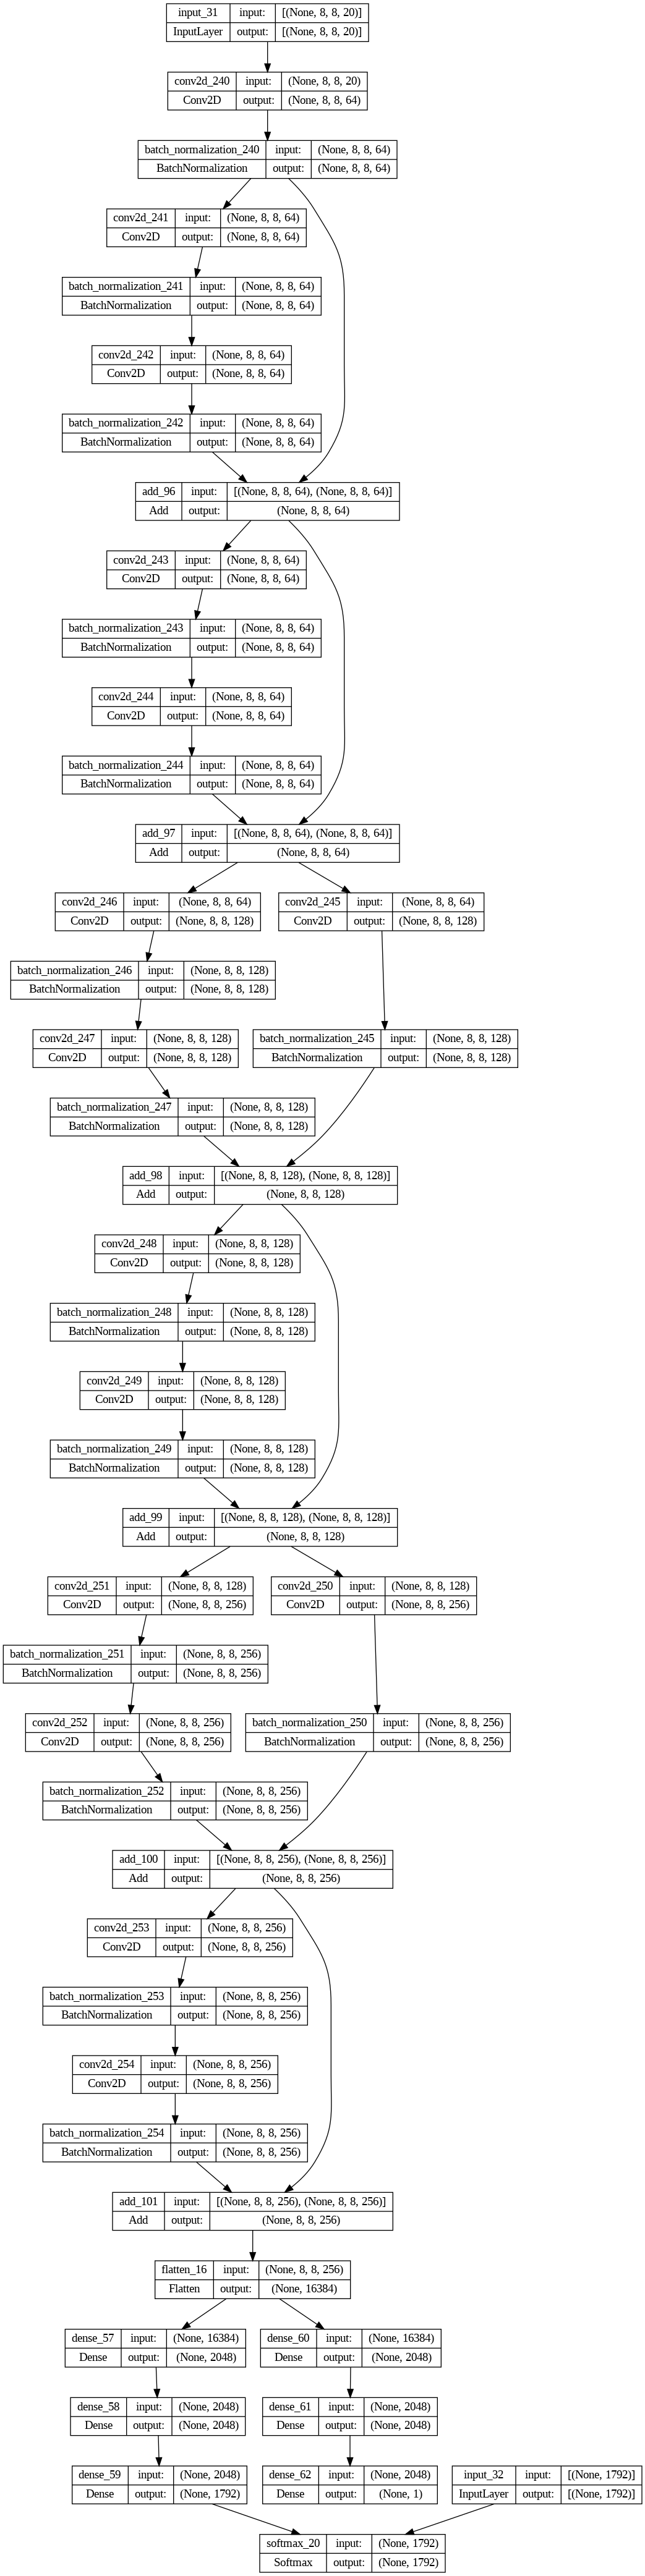

In [140]:
keras.utils.plot_model(model, show_shapes=True)

In [24]:
import time

In [25]:
"""
testData=np.random.rand(8192,8,8,20)
st=time.time()
for i in range(200):
    model(testData)
print((time.time()-st)/200)
"""

'\ntestData=np.random.rand(8192,8,8,20)\nst=time.time()\nfor i in range(200):\n    model(testData)\nprint((time.time()-st)/200)\n'

## Prelimary test of if it can play chess

In [26]:
"""
#This code is designed to make sure that when untrained the model will still be able to find desisive results and therefore non-trivial rewards.

board=chess.Board()
gameLengths=[]
model=dualHeadedResNet(blocks=3, activation="relu", factor=2, initialFilters=64, denseLatent=2048)
while not board.is_checkmate():
    board.reset()
    i=0
    while not board.is_game_over():
        i+=1
        output=model.predict(boardToInput(board), verbose=0)
        policy=output[0][0]
        mask=getLegelMovesMask(board)
        masked_output=policy* mask
        output_with_nan=np.where(masked_output == 0, np.nan, masked_output)
        softmax_output=np.exp(output_with_nan)/np.nansum(np.exp(output_with_nan))
        indexes=np.array(range(len(moveList)))
        moveIndex=moveList[np.random.choice(indexes, p=np.where(np.isnan(softmax_output), 0, softmax_output))]
        from_square=moveIndex//64
        to_square=moveIndex%64
        if (board.piece_at(from_square).piece_type == chess.PAWN) and (to_square//8 in (0,7)):
            move=chess.Move(from_square, to_square, promotion=chess.QUEEN)
        else:
            move=chess.Move(from_square, to_square)
        board.push(move)
        if i % 100 ==0:
            print(i)
            display(IPython.display.HTML(svg.board(board=board, size=300)))
    gameLengths.append(i)
    display(IPython.display.HTML(svg.board(board=board, size=300)))
    print(board.result())
print(gameLengths)
print(len(gameLengths))
print(sum(gameLengths)/len(gameLengths))
"""

'\n#This code is designed to make sure that when untrained the model will still be able to find desisive results and therefore non-trivial rewards.\n\nboard=chess.Board()\ngameLengths=[]\nmodel=dualHeadedResNet(blocks=3, activation="relu", factor=2, initialFilters=64, denseLatent=2048)\nwhile not board.is_checkmate():\n    board.reset()\n    i=0\n    while not board.is_game_over():\n        i+=1\n        output=model.predict(boardToInput(board), verbose=0)\n        policy=output[0][0]\n        mask=getLegelMovesMask(board)\n        masked_output=policy* mask\n        output_with_nan=np.where(masked_output == 0, np.nan, masked_output)\n        softmax_output=np.exp(output_with_nan)/np.nansum(np.exp(output_with_nan))\n        indexes=np.array(range(len(moveList)))\n        moveIndex=moveList[np.random.choice(indexes, p=np.where(np.isnan(softmax_output), 0, softmax_output))]\n        from_square=moveIndex//64\n        to_square=moveIndex%64\n        if (board.piece_at(from_square).piece_t

In [27]:
"""
General replay buffer class. In practice we will use 3 of them, 1 to store positions from games that ended in a win, one for those that ended in a loss,
and one for those that ended in draws. Each entry will store a board, a policy, and a value. The board array will be in the input format of
shape=(size,8,8,20) the policy array will be of shape=(size,len(moveList)) and the value array will be of shape=(size,1). These will be used
to train and model and will be regularly updated in the style of a queue with more up to date games.
"""
#Has been unit tested
class replayBuffer(object):
    def __init__(self,size: int=20000):
        assert type(size)==int, "size must be an integer"
        self.size=size
        self.length=0 #Length will keep track of the index after the last added entry so implement first in first out behavior
        self.entries=0 #Entries will keep track of how many events the buffer is currently storing
        self.boardList=np.zeros((size,8,8,20), dtype=np.byte) #Net pieces layer will be between -103 and 103 while the other layers will be -1, 0, or 1
        self.policyList=np.zeros((size,len(moveList)), dtype=np.float32)
        self.valueList=np.zeros((size,1), dtype=np.byte)

    def add(self, board: np.ndarray , policy: np.ndarray, value: int):
        assert type(board)==np.ndarray, "board must be a numpy array"
        assert board.shape==(1,8,8,20) or board.shape==(8,8,20), "board must be of shape (1,8,8,20) or (8,8,20)"
        assert policy.shape==(1,len(moveList)) or policy.shape==(len(moveList),), "policy must be of shape (1,len(moveList)) or (len(moveList),)"
        assert type(value)==int, "value must be an integer"
        self.boardList[self.length]=board
        self.policyList[self.length]=policy
        self.valueList[self.length]=value
        if self.length<self.size-1:
            self.length+=1
        else:
            self.length=0
        if self.entries<self.size:
            self.entries+=1

    def remove(self, num: int):
        assert type(num)==int, "num must be an integer"

        if self.entries >= num:
            self.entries-=num
            if self.length+num<=self.size:
                self.boardList[self.length:self.length+num]=0
                self.policyList[self.length:self.length+num]=0
                self.valueList[self.length:self.length+num]=0

            else:
                self.boardList[self.length:]=0
                self.policyList[self.length:]=0
                self.valueList[self.length:]=0
                self.boardList[:(self.length+num-self.size)]=0
                self.policyList[:(self.length+num-self.size)]=0
                self.valueList[:(self.length+num-self.size)]=0


        else:
            self.entries=0
            self.boardList=np.zeros((self.size,8,8,20), dtype=np.byte)
            self.policyList=np.zeros((self.size,len(moveList)), dtype=np.float32)
            self.valueList=np.zeros((self.size,1), dtype=np.float32)


    def batch(self, batchsize):
        assert type(batchsize)==int, "batchsize must be an integer"
        if batchsize > self.entries:
            batchsize=self.entries
        indices=np.random.choice(self.length-self.entries+np.arange(self.entries), batchsize, replace=False)
        return self.boardList[indices], self.policyList[indices], self.valueList[indices]

    def __len__(self):
        return self.entries

    def __getitem__(self, index):
        return self.boardList[index], self.policyList[index], self.valueList[index]

    def __setitem__(self, index, value):
        self.boardList[index]=value[0]
        self.policyList[index]=value[1]
        self.valueList[index]=value[2]

    def __delitem__(self, index):
        self.boardList[index]=0
        self.policyList[index]=0
        self.valueList[index]=0

    def __repr__(self):
        return f"replayBuffer(size={self.size}, entries={self.entries}, length={self.length})"

In [29]:
# Unit tests for replayBuffer

model=dualHeadedResNet(3, activation="relu", factor=2, initialFilters=64, denseLatent=2048)
size=12
buffer=replayBuffer(size)
board=chess.Board()
for i in range(50):
    np.random.seed(i)
    board.push(np.random.choice((*board.legal_moves,)))
    input=boardToInput(board)
    policy=model(input)[0][0]
    print(type(policy))
    value=model(input)[1][0]
    buffer.add(input, policy, 1)
    assert len(buffer)==min(i+1,size)

buffer.remove(2)
assert len(buffer)==min(i+1,size)-2

batch=buffer.batch(6)
assert batch[0].shape==(6,8,8,20)
assert batch[1].shape==(6,len(moveList))
assert batch[2].shape==(6,1)

batch=buffer.batch(size+10)
assert batch[0].shape==(size-2,8,8,20)
assert batch[1].shape==(size-2,len(moveList))
assert batch[2].shape==(size-2,1)

assert buffer[0][0].shape==(8,8,20)
assert buffer[0][1].shape==(len(moveList),)
assert type(buffer[0][2][0])==np.byte

del buffer[0]
assert buffer[0][0].shape==(8,8,20)
assert buffer[0][1].shape==(len(moveList),)
assert type(buffer[0][2][0])==np.byte
assert buffer[0][0][0,0,0]==0
assert buffer[0][1][0]==0
assert buffer[0][2][0]==0

buffer[0]=(boardToInput(board), policy, 1)
assert buffer[0][0].shape==(8,8,20)
assert buffer[0][1].shape==(len(moveList),)
assert type(buffer[0][2][0])==np.byte

del buffer

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.fr